In [1]:
#Use this window to import packages you will use later
#When you first start working or import a new package, this cell needs to be run before doing anything else.


import numpy as np
import pylab
import matplotlib
import matplotlib.gridspec as gridspec

import scipy

import astropy.io.fits as fits

from astropy.wcs import WCS
from astropy import units as u

import regions

import pyspeckit as psk

from spectral_cube import SpectralCube

from reproject import reproject_interp
from reproject.mosaicking import find_optimal_celestial_wcs 

# Suppress warnings we don't care about:
import sys
if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")
    
# Embeds plots in the Jupyter window 
%matplotlib inline                             

matplotlib.rc('text', usetex=True)
#matplotlib.rc('font', family='sans-serif')
font = {'family' : 'sans-serif',
        'weight' : 'bold',
        'size'   : 22}
matplotlib.rc('font', **font)

datadir = "../data/"
linedir = datadir + "smoothed_repixelized/"

filenames = {
    'ar2': 'NGC253_ArII_7.0.line.sm0.96.rgFeII26.fits',
    'ar3': 'NGC253_ArIII_9.0.line.sm0.96.rgFeII26.fits',
    'ch2': 'NGC253_C2H2_13.7um.line.sm0.96.rgFeII26.fits',
    'cl2': 'NGC253_ClII_14.4.line.sm0.96.rgFeII26.fits',
    'NGC253_FeII_17.9.line.sm0.96.rgFeII26.fits',
    'NGC253_FeII_5.3.line.sm0.96.rgFeII26.fits',
    'NGC253_FeIII_22.9.line.sm0.96.rgFeII26.fits',
    'NGC253_H2_S1_17.0.line.sm0.96.rgFeII26.fits',
    'NGC253_H2_S2_12.3.line.sm0.96.rgFeII26.fits',
    'NGC253_H2_S3_9.7.line.sm0.96.rgFeII26.fits',
    'NGC253_H2_S4_8.0.line.sm0.96.rgFeII26.fits',
    'NGC253_H2_S5_6.9.line.sm0.96.rgFeII26.fits',
    'NGC253_H2_S6_6.1.line.sm0.96.rgFeII26.fits',
    'NGC253_H2_S7_5.5.line.sm0.96.rgFeII26.fits',
    'NGC253_H2_S8_5.0.line.sm0.96.rgFeII26.fits',
    'NGC253_H5a_7.4.line.sm0.96.rgFeII26.fits',
    'NGC253_H6a_12.4.line.sm0.96.rgFeII26.fits',
    'NGC253_H6b_7.5.line.sm0.96.rgFeII26.fits',
    'NGC253_H6g_5.9.line.sm0.96.rgFeII26.fits',
    'NGC253_HCNv2_14um.line.sm0.96.rgFeII26.fits',
    'NGC253_He_6.7.line.sm0.96.rgFeII26.fits',
    'NGC253_HNCv2_21.6um.line.sm0.96.rgFeII26.fits',
    'NGC253_NeII_12.8.line.sm0.96.rgFeII26.fits',
    'NGC253_NeIII_15.6.line.sm0.96.rgFeII26.fits',
    'NGC253_NeV_14.3.line.sm0.96.rgFeII26.fits',
    'NGC253_NeVI_7.6.line.sm0.96.rgFeII26.fits',
    'NGC253_NiIII_7.3.line.sm0.96.rgFeII26.fits',
    'NGC253_OIV_25.9.line.sm0.96.rgFeII26.fits',
    'NGC253_PIII_17.8.line.sm0.96.rgFeII26.fits',
    'NGC253_SIII_18.7.line.sm0.96.rgFeII26.fits',
    'NGC253_SIV_10.5.line.sm0.96.rgFeII26.fits'}
#'NGC253_sky_v1_17_1_ch1-shortmediumlong_s3d_smooth.regrid-ch4.mask.fits',
#'NGC253_sky_v1_17_1_ch2-shortmediumlong_s3d_smooth.regrid-ch4.mask.fits',
#'NGC253_sky_v1_17_1_ch3-shortmediumlong_s3d_smooth.regrid-ch4.mask.fits',
#'NGC253_sky_v1_17_1_ch4-shortmediumlong_s3d_smooth.mask.fits'


#print("all imported")

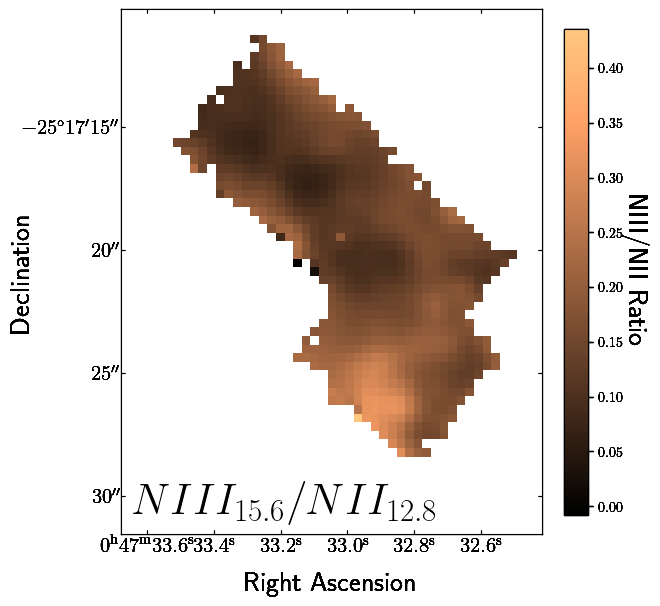

In [8]:
# Extract moment maps and calculate ratios for selected line fluxes
# Will want to generalize this into a function once the kinks are ironed out


neiii_156 = SpectralCube.read(linedir + 'NGC253_NeIII_15.6.line.sm0.96.rgFeII26.fits')    
#print(neiii_156)                                              

neii_128 = SpectralCube.read(linedir + 'NGC253_NeII_12.8.line.sm0.96.rgFeII26.fits')
#print(neii_128)

# These are the same size and shape
neiii_156_kms = neiii_156.with_spectral_unit(u.km/u.s, velocity_convention="optical")
neiii_156_kms.allow_huge_operations = True
neiii_156_K_kms = neiii_156_kms.to(u.K)  # Converts to Kelvin for the units
neii_128_kms = neii_128.with_spectral_unit(u.km/u.s, velocity_convention="optical")
neii_128_kms.allow_huge_operations = True
neii_128_K_kms = neii_128_kms.to(u.K)

# Calculate Moment 0 maps
neiii_156_moment0  = neiii_156_K_kms.moment(order=0, how='slice')
neii_128_moment0  = neii_128_K_kms.moment(order=0, how='slice')

# The below reprojection should not be necessary since the two moment maps are same size and shape, but maybe we want to include it for redundancy when generalizing this code?
neiii_156_moment0_reproject, footprint = reproject_interp(neiii_156_moment0.hdu,neii_128_moment0.header)

# Compute ratio maps
ratio_NIII_NII = neiii_156_moment0_reproject/neii_128_moment0.hdu.data

# Not sure what kind of mask we want to use here, if any
#badpix = pylab.where(neiii_156_moment0.hdu.data<10)     # Identify emission below a threshold to mask
#badpix2 = pylab.where(neii_128_moment0.hdu.data<0)     # Mask absorption
#ratio_NIII_NII[badpix] = np.nan                        # Mask the ratio map
#ratio_NIII_NII[badpix2] = np.nan

# Make figure
fig1 = pylab.figure(1,figsize=(15,15))
# Plot ratio
ax1 = pylab.subplot(2,2,1,projection=neii_128_moment0.wcs) 
im1 = pylab.imshow(ratio_NIII_NII,cmap='copper')
RA = ax1.coords[0]                                                                  
Dec = ax1.coords[1]
RA.set_ticks(size=-3)                                                                                      
Dec.set_ticks(size=-3)                                                                                    
pylab.xlabel('Right Ascension',fontsize=20,labelpad=1)                               
pylab.ylabel('Declination',fontsize=20,labelpad=0)
ax1.tick_params(axis = 'both', which = 'major', labelsize = 15)
cb=pylab.colorbar(im1,fraction=0.046,pad=0.04)                                      
cb.set_label(label='NIII/NII Ratio',fontsize=20,rotation=270,labelpad=20) 
cb.ax.tick_params(which = 'major', labelsize = 10)   
pylab.annotate(text='$NIII_{15.6}/NII_{12.8}$',fontsize=32,xy=(0.03,0.04),xycoords="axes fraction")
display(fig1)

In [1]:
def calculate_ratio_map(dirstrone, dirstrtwo, annotation='', lab=''):
    # Extract moment maps and calculate ratios for selected line fluxes
    # Will want to generalize this into a function once the kinks are ironed out
    
    
    ione = SpectralCube.read(linedir + dirstrone)    
    #print(ione)                                              
    
    itwo = SpectralCube.read(linedir + dirstrtwo)
    #print(itwo)
    
    # These are the same size and shape
    
    ione_kms = ione.with_spectral_unit(u.km/u.s, velocity_convention="optical")
    ione_kms.allow_huge_operations = True
    ione_K_kms = ione_kms.to(u.K)  # Converts to Kelvin for the units
    itwo_kms = itwo.with_spectral_unit(u.km/u.s, velocity_convention="optical")
    itwo_kms.allow_huge_operations = True
    itwo_K_kms = itwo_kms.to(u.K)
    
    # Calculate Moment 0 maps
    ione_moment0  = ione_K_kms.moment(order=0, how='slice')
    itwo_moment0  = itwo_K_kms.moment(order=0, how='slice')
    
    # The below reprojection should not be necessary since the two moment maps are same size and shape, but maybe we want to include it for redundancy when generalizing this code?
    ione_moment0_reproject, footprint = reproject_interp(ione_moment0.hdu,itwo_moment0.header)
    
    # Compute ratio maps
    ratio_ione_itwo = ione_moment0_reproject/itwo_moment0.hdu.data
    
    # Not sure what kind of mask we want to use here, if any
    #badpix = pylab.where(ione_moment0.hdu.data<10)     # Identify emission below a threshold to mask
    #badpix2 = pylab.where(itwo_moment0.hdu.data<0)     # Mask absorption
    #ratio_NIII_NII[badpix] = np.nan                        # Mask the ratio map
    #ratio_NIII_NII[badpix2] = np.nan
    
    # Make figure
    fig1 = pylab.figure(1,figsize=(15,15))
    # Plot ratio
    ax1 = pylab.subplot(2,2,1,projection=itwo_moment0.wcs) 
    im1 = pylab.imshow(ratio_ione_itwo,cmap='copper')
    RA = ax1.coords[0]                                                                  
    Dec = ax1.coords[1]
    RA.set_ticks(size=-3)                                                                                      
    Dec.set_ticks(size=-3)                                                                                    
    pylab.xlabel('Right Ascension',fontsize=20,labelpad=1)                               
    pylab.ylabel('Declination',fontsize=20,labelpad=0)
    ax1.tick_params(axis = 'both', which = 'major', labelsize = 15)
    cb=pylab.colorbar(im1,fraction=0.046,pad=0.04)                                      
    cb.set_label(label=lab,fontsize=20,rotation=270,labelpad=20) 
    cb.ax.tick_params(which = 'major', labelsize = 10)   
    pylab.annotate(text=annotation,fontsize=32,xy=(0.03,0.04),xycoords="axes fraction")
    display(fig1)